# Land a rocket (and a good game) with reinforcement learning

Use this notebook to train your lunar lander agent! This notebook provides detailed instructions on how to get started by tuning hyperparameters, building docker images, training RL models, analyzing outputs, and more.

# Step 1: Setting the scene

**Scenario:** You want to land your lunar lander as accurately as possible on coordinate (0,0) with minimal fuel usage. You need to land directly on the landing pad and you want to make sure you have enough fuel to get back to Earth! 

This code cell first defines that we are using the [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) problem in the [Box2D](https://gym.openai.com/envs/#box2d) environment from [OpenAI Gym](https://openai.com/). 

It then sets the training algorithm to **PPO** which stands for Proximal Policy Optimization. This is a new class of reinforcement learning algorithms that is easy to use and offers good performance. You can read more about PPO [here](https://openai.com/blog/openai-baselines-ppo/#ppo).

Finally, it imports necessary files for training.

1. Keep everything in the cells of this tutorial notebook default. 
2. **Run** the following code cell. 

**Tip:** Run individual code cells by hitting the **Run** button in the toolbar above. Run all code cells in this notebook in order by selecting the **fast forward (>>)** button in the toolbar above, found next to the **refresh** button. When a code cell is in the process of running, you will see **In[\*]** to the left of the code cell. When the code cell is finished executing, you will see a number, like **In[3]**


In [1]:
box2d_problem = 'lunarlander'

# Algorithm 
algo = 'PPO'

trainscript = 'hyperparameters.py'

In [2]:
trainscript

'hyperparameters.py'

### States

What are the states of this agent? This is a sample that shows how the state of the lunar lander agent is determined. It contains information about the state of the agent at every step of the process, including the position of the agent for example. 

```python
pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W/SCALE/2) / (VIEWPORT_W/SCALE/2), # x position
            (pos.y - (self.helipad_y+LEG_DOWN/SCALE)) / (VIEWPORT_H/SCALE/2), # y position
            vel.x*(VIEWPORT_W/SCALE/2)/FPS, # velocity on the x axis
            vel.y*(VIEWPORT_H/SCALE/2)/FPS, # velocity on the y axis
            self.lander.angle, # angle of the lunar lander
            20.0*self.lander.angularVelocity/FPS, # rotation of the lunar lander
            1.0 if self.legs[0].ground_contact else 0.0, # leg 0 having ground contact
            1.0 if self.legs[1].ground_contact else 0.0 # leg 1 having ground contact
]
```        

### Actions

What are the actions the agent can take? For example, the agent might be able to take no action. Or maybe the agent fires the left engine, or the main engine, or the right engine. 

According to Pontryagin's maximum principle, it is optimal to fire the engine full throttle or turn it off. That's the reason this environment is OK to have discreet actions (engine on or off).

```python        
        if self.continuous:
            # Action is two floats [main engine, left-right engines].
            # Main engine: -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power.
            # Left-right:  -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off
            self.action_space = spaces.Box(-1, +1, (2,), dtype=np.float32)
        else:
            # Nop, fire left engine, main engine, right engine
            self.action_space = spaces.Discrete(4)
```

### Reward

How is the agent rewarded? This is a sample reward function for the lunar lander agent. In this function, you can see that the reward increases or decreases depending on the state of the lunar lander agent. For example, if you want a level landing, the reward increases for each leg that contacts with the moon. This is to train the lunar lander to land right-side up instead of upside down. To a similar effect, the reward decreases depending on how much fuel is used. This is to train the lunar lander to conserve as much fuel as possible. 

The reward is officially calculated as follows:

The landing pad is always at coordinates (0,0). The coordinates are the first two numbers in the state vector shown below. The reward for moving from the top of the screen to the landing pad with zero speed is about 100-140 points.
If the lander moves away from landing pad, it loses reward. The episode finishes if the lander crashes or
comes to a rest, receiving an additional -100 or +100 points respectively. Each leg ground contact is +10. Firing the main engine is -0.3 points each frame. Firing the side engine is -0.03 points each frame. Solving the lunar lander is 200 points.

Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land
on its first attempt. You can see the source code for more details. 

```python
        reward = 0
        shaping = \
            - 100*np.sqrt(state[0]*state[0] + state[1]*state[1]) \ # Position X and Y to identify the center
            - 100*np.sqrt(state[2]*state[2] + state[3]*state[3]) \ # Velocity of X and Y
            - 100*abs(state[4]) + 10*state[6] + 10*state[7] # Angle, rotation, and legs landing on the moon
        # Add ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        reward -= m_power*0.30  # main engine firing penalty -- less fuel spent is better
        reward -= s_power*0.03 # side engine firing penalty

        done = False
        if self.game_over or abs(state[0]) >= 1.0:
            done   = True
            reward = -100
        if not self.lander.awake:
            done   = True
            reward = +100
```

###  Editing the reward function

 You can edit this reward function to change the behavior of your lunar lander agent. You can find and edit it in the `src/reward_function.py` file.

# Step 2: Set prerequisites 

### Imports

To get started, we'll import the Python libraries we need and set up the environment with a few prerequisites for permissions and configurations. This code cell imports necessary Python libraries, like **boto3** which is the AWS SDK for Python.

3. Run the code cell below to set the prerequisites needed for this workshop by hitting the **Run** button in the toolbar above.
 

In [3]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
import numpy as np
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from docker_utils import build_and_push_docker_image
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

# Step 3: Setup S3 bucket

Next, we need to set up the linkage and authentication to an S3 bucket. This will be the bucket where SageMaker stores the output data of training jobs. SageMaker also stores the trained models as **model.tar.gz** files in this S3 bucket, as well as checkpoints and other metadata. 

4. Run the code cell below by hitting the **Run** button in the toolbar above.

This code cell creates a SageMaker session, which helps to manage interactions with the Amazon SageMaker APIs and any other AWS services needed, like S3. The S3 bucket is set to the default SageMaker bucket and the output path of this bucket is defined.

In [4]:
sage_session = sagemaker.session.Session()
s3_bucket = sage_session.default_bucket()  
s3_output_path = 's3://{}/'.format(s3_bucket)
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://sagemaker-eu-west-1-965916812793/


# Step 4: Define variables and configure training

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

5. **Run** the code cell below to set the job name.

In [27]:
# create a descriptive job name 
job_name_prefix = 'Jonas-rl-box2d-'+box2d_problem

### Configure where training happens

You can train your RL training jobs using the SageMaker notebook instance or local notebook instance. In both of these scenarios, you can run the following in either local or SageMaker modes. The local mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

6. For now, leave this cell default with local_mode set to **False**.

7. **Run** the code cell.

In [28]:
# run in local_mode on this machine, or as a SageMaker TrainingJob
local_mode = False

if local_mode:
    instance_type = 'local'
else:
    # If on SageMaker, pick the instance type
    instance_type = "ml.p3.8xlarge"

**Tip:** In the future, you can fire off multiple training jobs on different instance types by changing the instance type below before training. Right now, the instance type is **ml.p3.8xlarge**. For this workshop, you have the ability to use the follow instance types for distributed training:

* (2) ml.p3.2xlarge instances

* (2) ml.p3.8xlarge instances

* (2) ml.p3.16xlarge instances

* (2) ml.c5.xlarge instances

* (2) ml.c5.2xlarge instances

* (2) ml.c5.4xlarge instances

* (2) ml.c5.9xlarge instances

* (2) ml.c5.18xlarge instances

You also have access to any of the [default SageMaker limits](https://docs.aws.amazon.com/general/latest/gr/sagemaker.html). To find out what instances are currently in use just run the cell below.

In [29]:
#Run this cell to see what training instances are currently running in this account
#This way, you can choose other training instances to avoid resource limit errors. 

import boto3
client = boto3.client('sagemaker')
jobs = client.list_training_jobs()['TrainingJobSummaries']

print("Instance types currently in use for training:")
for job in jobs:
    if job['TrainingJobStatus'] == 'InProgress' or job['TrainingJobStatus'] == 'Stopping' :
        in_use = client.describe_training_job(TrainingJobName=job['TrainingJobName'])['ResourceConfig']
        print("Type: {}, No. of instances: {}".format(in_use['InstanceType'], in_use['InstanceCount']))
        
#If nothing prints, all instances listed above are free to use

Instance types currently in use for training:


### Create an IAM role

Either get the execution role when running from a SageMaker notebook instance `role = sagemaker.get_execution_role()` or, when running from local notebook instance, use utils method `role = get_execution_role()` to create an execution role.

8. **Run** this code cell to ceate an IAM role for SageMaker.

In [30]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()

print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::965916812793:role/mod-2a01731acb2241e7-SagemakerIAM-QWZCT9HW600I


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker and docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

9. **Run** the code cell below. 

**Tip:** You can only run a single local notebook at one time.

In [31]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

# Step 5: Build docker container

We must build a custom docker container with Roboschool installed.  This takes care of everything:

* Fetching base container image
* Installing Roboschool and its dependencies
* Uploading the new container image to ECR

This step can take a long time if you are running on a machine with a slow internet connection.  If your notebook instance is in SageMaker or EC2 it should take 3-10 minutes depending on the instance type.

10. **Run** the code cell to build the docker container. 

**Tip:** The output should say `Done pushing` when the build is finished. If your build seems to be hung up on something, either not progressing or looks like it is not running at all, refresh your notebook and try again.

In [32]:
%%time

cpu_or_gpu = 'gpu' if instance_type.startswith('ml.p') else 'cpu'
repository_short_name = box2d_problem+"-%s" % cpu_or_gpu
docker_build_args = {
    'CPU_OR_GPU': cpu_or_gpu, 
    'AWS_REGION': boto3.Session().region_name
}
custom_image_name = build_and_push_docker_image(repository_short_name, build_args=docker_build_args)
print("Using ECR image %s" % custom_image_name)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Logged into ECR
Building docker image lunarlander-gpu from Dockerfile
$ docker build -t lunarlander-gpu -f Dockerfile . --build-arg CPU_OR_GPU=gpu --build-arg AWS_REGION=eu-west-1
Sending build context to Docker daemon  825.3kB
Step 1/31 : ARG CPU_OR_GPU
Step 2/31 : ARG AWS_REGION
Step 3/31 : FROM 520713654638.dkr.ecr.${AWS_REGION}.amazonaws.com/sagemaker-rl-tensorflow:ray0.6.5-${CPU_OR_GPU}-py3
 ---> f038be2cc8c4
Step 4/31 : WORKDIR /opt/ml
 ---> Using cache
 ---> 640c9c38cda4
Step 5/31 : RUN apt-get update
 ---> Using cache
 ---> 0c0fd07a74d7
Step 6/31 : RUN apt-get install sudo
 ---> Using cache
 ---> a01d194207e7
Step 7/31 : RUN apt-get update && apt-get install -y --no-in

latest: digest: sha256:cca0216380741a12898d50af587e7d2e6a7fadae0c5c24b0fc6d5c199b596c8c size: 9972
Done pushing 965916812793.dkr.ecr.eu-west-1.amazonaws.com/lunarlander-gpu
Using ECR image 965916812793.dkr.ecr.eu-west-1.amazonaws.com/lunarlander-gpu
CPU times: user 126 ms, sys: 61.1 ms, total: 187 ms
Wall time: 1.53 s


In [33]:
custom_image_name

'965916812793.dkr.ecr.eu-west-1.amazonaws.com/lunarlander-gpu'

# Step 6: Write the Training Code

The training code is written in the file `hyperparameters.py` which is uploaded in the `/src` directory.
First import the environment files and the preset files, and then define the main() function.  

In [34]:
!pygmentize src/{trainscript}

import json
import os

import gym
import ray
from ray.tune import run_experiments
from ray.tune.registry import register_env

from sagemaker_rl.ray_launcher import SageMakerRayLauncher


def create_environment(env_config):
    # This import must happen inside the method so that worker processes import this code
    return gym.make('LunarLander-v2')


class MyLauncher(SageMakerRayLauncher):

    def register_env_creator(self):
        register_env("LunarLander-v2", create_environment)
        
    #This is where you edit the hyperparameters. Change the values in the config section listed below.
    #The hyperparameters we recommend on changing are: lambda, kl_coeff, vf_loss__coeff, num_sgd_iter, clip_param
    #Check the notebook Step 6 for tips on tuning hyperparameters. 
    def get_experiment_config(self):
        return {
          "training": { 
            "env": "LunarLander-v2",
            "run": "PPO",
            "stop": {
                "episode_reward_mean": 0,
           

## Hyperparameters

To tune hyperparameters, find the `hyperparameters.py` file in the `/src` folder of your SageMaker notebook. You can tune hyperparameters by editing the values in the `def get_experiment_config(self):` function. Below is a description of what the hyperparameters are.

11. For the tutorial, leave the hyperparameters as **default** and continue on running the code cells in this notebook.

Please see https://arxiv.org/abs/1707.06347 and https://arxiv.org/pdf/1506.02438.pdf for details 


**"lambda": 1.0**

    # Lambda parameter corresponds to the discount factor used in discounted formulations of Markov Decision Processes (MDPs). This is a numeric value to have the agent evaluate rewards from the current run versus rewards in the future. For a value of 0 this means the agent is short sighted and only cares about the first reward but for a value of 1 the agent cares about all future rewards. Recommended range is 0.7-1
    
**"kl_coeff": 0.2**

    # Initial coefficient of Kullback-Leibler (KL) Divergence between the previous value function and the new value function. The KL Divergence coefficient is looking at how well a single probabilistic outcome is able to predict another. In reinforcement learning, a lower but non-zero number is recommended, so somewhere between 0.003 - 0.3
    
**"vf_loss_coeff": 1.0**

    # Scaling value function loss to make it comparable in scale to the policy loss. This allows us to train an agent that is able to identify the best (or least cost) policy (or set of actions) that result in an favorable outcome. This hyperparementer scales how the agent policy is reflected to the overall value function outcome. Range 0.5 -1
    
**"num_sgd_iter": 30**

    # Number of Stochastic Gradient Descent (SGD) iterations in each outer loop while learning the value function. This means that we are using some randomness in finding the most optimal agent behavior. Range can be 3-30
    
**"clip_param": 0.3**

    # Proximal Policy Optimization (PPO) clip parameter for limiting the surrogate function during exploration. This hyper parameter allows an agent to explore within a specific range based upon the previous actions taken to allow iterative changes that push the agent to better performance. Range of 0.1 - 0.3 for the lunar lander simulation.
    
  
    
### HINTS:

Here are some hints for how to tune the hyperparameters above to best optimize your lunar lander agent:

* dramatically reduce **clip_param**
* slightly reduce **lambda**
* reduce **num_sgd_iter**
* reduce **vf_loss_coeff**
* reduce **kl_coeff**

**Tip:** You can minimize training time by editing the `hyperparameter.py` file in the `/src` directory by setting the `training_iteration` parameter to something lower than what is it by default, which is 50 training iterations. For example, to lower training time you can change it to 20 iterations.

# Step 7: Train the RL model using the Python SDK Script mode

If you are using local mode, the training will run on the notebook instance. When using SageMaker for training, you can select a GPU or CPU instance. The RLEstimator is used for training RL jobs. This code cell does the following:

* Specifies the source directory where the environment, presets and training code is uploaded.
* Specifies the entry point as the training code 
* Specifies the choice of RL toolkit and framework. This automatically resolves to the ECR path for the RL Container. 
* Defines the training parameters such as the instance count, job name, S3 path for output and job name. 
* Specifies the hyperparameters for the RL agent algorithm. The RLCOACH_PRESET or the RLRAY_PRESET can be used to specify the RL agent algorithm you want to use. 
* Defines the metrics definitions that you are interested in capturing in your logs. These can also be visualized in CloudWatch and SageMaker Notebooks. 


12. **Run** this code cell to begin training your RL model. It should take about 10-15 minutes for training to complete. Training time is capped at around 16 minutes as a time constraint for this workshop.

**Tip:** You can also monitor the progress of your training job by going back to the Amazon SageMaker Management Console and find the **Training jobs** link in the left navigation pane.

If you run into an error saying `ResourceLimitExceeded`, then change the EC2 instance type that training is happening on in **Step 4** above.

In [52]:
metric_definitions = RLEstimator.default_metric_definitions(RLToolkit.RAY)

In [53]:
metric_definitions.append({'Name': 'dist_from_center','Regex': 'dist_from_center=(.*?);'})
metric_definitions.append({'Name': 'vel_at_end','Regex': 'vel_at_end=(.*?);'})
metric_definitions.append({'Name': 'angle_at_end','Regex': 'angle_at_end=(.*?);'})
metric_definitions.append({'Name': 'fuel_used','Regex': 'fuel_used=(.*?);'})

In [54]:
%%time
    
estimator = RLEstimator(entry_point=trainscript,
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        image_name=custom_image_name,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=2,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        metric_definitions=metric_definitions,
                        train_max_run=500 
                    )

estimator.fit(wait=False)
job_name = estimator.latest_training_job.job_name
print("Training job: %s" % job_name)

Training job: Jonas-rl-box2d-lunarlander-2020-05-19-19-19-52-563
CPU times: user 109 ms, sys: 12.7 ms, total: 121 ms
Wall time: 410 ms


# Step 8: Visualization

RL training can take a long time.  So while it's running there are a variety of ways we can track progress of the running training job.  Some intermediate output gets saved to S3 during training, so we'll set up to capture that. This code cell defines the path to where outputs are stored for specific training jobs. 

13. Always keep everything default in this code cell and **run** it. 

In [55]:
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: Jonas-rl-box2d-lunarlander-2020-05-19-19-19-52-563
S3 job path: s3://sagemaker-eu-west-1-965916812793/Jonas-rl-box2d-lunarlander-2020-05-19-19-19-52-563
Intermediate folder path: s3://sagemaker-eu-west-1-965916812793/Jonas-rl-box2d-lunarlander-2020-05-19-19-19-52-563/output/intermediate/
Create local folder /tmp/Jonas-rl-box2d-lunarlander-2020-05-19-19-19-52-563


## Fetch videos of training rollouts

Videos of certain rollouts get written to S3 during agent training.  Here we fetch the last 10 videos from S3, and render the last one.

14. **Run** the following code cells to get the most recent video outputs of your trained lunar lander agent. You will be able to display the video in the SageMaker notebook itself. Hit **Run interact** to play the latest video. 

In [56]:
recent_videos = wait_for_s3_object(
            s3_bucket, intermediate_folder_key, tmp_dir, 
            fetch_only=(lambda obj: obj.key.endswith(".mp4") and obj.size>0), 
            limit=30, training_job_name=job_name)

Waiting for s3://sagemaker-eu-west-1-965916812793/Jonas-rl-box2d-lunarlander-2020-05-19-19-19-52-563/output/intermediate/.................................................................


In [57]:
# ls -l --block-size=M /tmp/{job_name}

In [58]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Video
import ipywidgets as widgets
video=0
def showvideo(i):
    last_video = sorted(recent_videos)[i]
    return Video.from_file(last_video)
print(len(recent_videos))

video = interact_manual(showvideo, i=widgets.IntSlider(min=0,max=len(recent_videos)-1,step=1,value=0));
print("Does landing look better for higher values of i, i.e. later videos?")

15


interactive(children=(IntSlider(value=0, description='i', max=14), Button(description='Run Interact', style=Bu…

Does landing look better for higher values of i, i.e. later videos?


## Plot metrics for training job

We can see the reward metric of the training as it's running, using algorithm metrics that are recorded in Amazon CloudWatch metrics. We can plot this to see the performance of the model over time.

15. **Run** the following code cell to view a plot of metrics from your training. 

16. You can also see the metrics in the **AWS Management Console** by finding your training job, clicking on it to expand details about it, and scrolling down to the Monitor section.

    * Do to this, make sure you are on the SageMaker Management Console.
    * Find the Training jobs link on the left navigation pane
    * Find your latest training job and click it to see more details.
    * Scroll down to the monitor section
    * You will be able to see plotted metrics like episode reward mean, episode reward max, as well as other metrics like CPU and memory utilization. 

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


Text(0.5, 0, 'Training time (s)')

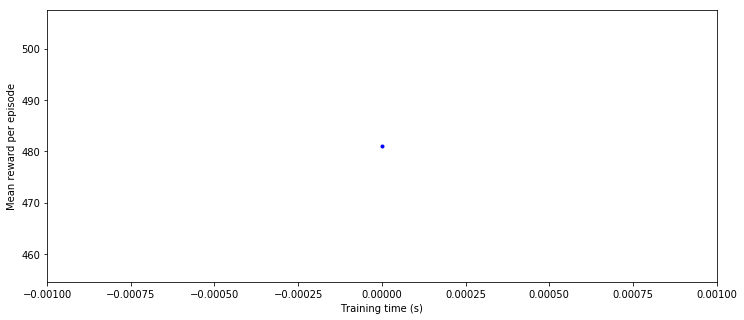

In [51]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

training_job_name = job_name
metric_name = 'episode_reward_mean'

metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
plt.set_ylabel(metric_name);

plt.set_ylabel('Mean reward per episode')
plt.set_xlabel('Training time (s)')

# Thank you!

You have finished exploring the SageMaker notebook, including understanding how to tune hyperparameters, build docker containers, editing the reward function, train your RL models, and visualize outputs. 

You can continue to use this notebook for training your agent by starting again at the top, editing the reward function and tuning hyperparameters as necessary to improve the performance of your lunar lander agent!

Make sure to keep an eye on the leaderboards. 